In [62]:
import sys
sys.path.append('../')

from game_runner import NegotitaionGame, GameEvaluator
import agents.simple_agent as simple_agent
import agents.llm_agent as llm_agent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prompting.make_prompt import make_prompt
from metrics.visualizations import (
    plot_discounted_values,
    plot_offer_evolution,
    plot_negotiation_gap,
    plot_fairness
)



In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
def calculate_discounted_value(offer, values, gamma, round_num):
    if offer is None:
        return 0
    base_value = sum(v * q for v, q in zip(values, offer))
    return base_value * (gamma ** (round_num - 1))


In [66]:
rounds = []
p1_values = []
p2_values = []
max_rounds = 4
p1_offers = []
p2_offers = []
game = NegotitaionGame(
    player1_agent=llm_agent.LLMAgent(),
    player2_agent=llm_agent.LLMAgent(),
    num_items=3,
    item_value_range=[0, 101],
    gamma=0.9,
    max_rounds=max_rounds,
    outside_offer_value_range=[1, 1000]
)

rounds = []
p1_values = []
p2_values = []

#LOOP TO RUN NEGOTIATION
while game.in_progress:  
    current_step = len(game.history[0]) + len(game.history[1]) + 1
    current_round = (current_step - 1) // 2 + 1 
    current_player = 1 if current_step % 2 == 1 else 2
    
    print(f"\n{'='*80}")
    print(f"Round {current_round}, Player {current_player}'s turn (Step {current_step})")
    print(f"{'='*80}")

    prev_offer = game.current_offer  
    game.step()  
    
    if game.current_offer: #NORMAL ROUNDS
        #p1_kept = game.items - np.array(game.current_offer.offer)
       # p1_value = calculate_discounted_value(p1_kept, game.player_values[0], game.gamma, current_round)
        #p2_value = calculate_discounted_value(game.current_offer.offer, game.player_values[1], game.gamma, current_round)
        
        if current_player == 1:
            p1_kept = game.items - np.array(game.current_offer.offer)
            p1_value = calculate_discounted_value(p1_kept, game.player_values[0], game.gamma, current_round)
            p2_value = calculate_discounted_value(game.current_offer.offer, game.player_values[1], game.gamma, current_round)
            rounds.append(current_round)
            p1_values.append(p1_value)
            p2_values.append(p2_value)
        if current_player == 2: #PLAYER 2 OFFERS
            rounds.append(current_round)
            p1_values.append(p1_value)
            p2_values.append(p2_value)
            p1_offers.append(prev_offer.offer)  
            p2_offers.append(game.current_offer.offer)
            print(f"\nRound {current_round} Values:")
            print(f"Player 1: {p1_value:.2f}")
            print(f"Player 2: {p2_value:.2f}")
    
    
    if current_round == game.max_rounds and current_player == 2: #IF WE ARE ON THE LAST ROUND
        if game.current_offer and game.current_offer != prev_offer: #IF PLAYER 2 MAKES A COUNTEROFFER WE TREAT IT AS WALK
            print(f"\nPlayer 2's final action: COUNTEROFFER {game.current_offer.offer}")
            p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
            p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
            print("\nGame ended after max rounds - both players get outside offers")
        elif game.current_offer == prev_offer: #IF PLAYER 2 ACCEPTS
            print("\nPlayer 2's final action: ACCEPT")
            p1_kept = game.items - np.array(game.current_offer.offer)
            p1_value = calculate_discounted_value(p1_kept, game.player_values[0], game.gamma, current_round)
            p2_value = calculate_discounted_value(game.current_offer.offer, game.player_values[1], game.gamma, current_round)
        else: #IF PLAYER 2 WALKS
            print("\nPlayer 2's final action: WALK")
            p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
            p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
            print("\nGame ended after max rounds - both players get outside offers")
        
        game.in_progress = False
        print(f"\nRound {current_round} Final Values:")
        print(f"Player 1: {p1_value:.2f}")
        print(f"Player 2: {p2_value:.2f}")
        
        rounds.append(current_round)
        p1_values.append(p1_value)
        p2_values.append(p2_value)
        break

if game.current_offer:
    print(f"\nFinal Values:")
    print(f"Player 1: {p1_values[-1]:.2f}")
    print(f"Player 2: {p2_values[-1]:.2f}")


Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 3 types of items, called item 1 through item 3.
    There are 5 units of item 1, 3 units of item 2, 2 units of item 3 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 99 for item 1, 39 for item 2, 1 for item 3.
    Both you and Player 2 also have a private outside offer, of value drawn from a uniform random distribution, ranging from 1 to 1000.
    Your outside offer value is 683.

    The negotiation proceeds in 4 rounds.
    There is a discount rate gamma = 0.9, such that if the process concludes after r rounds the overall value of the negotiation to each player is their value for the outcome multiplied by gamma to the power r-1 where r is the rou

## Discounted Values Over Time

For each offer/counter-offer:
- Blue line shows what Player 1 would receive from that division of items in their offer
- Red line shows what Player 2 would receive from that division of items counter offer


So each point on the graph shows the value each player would get if that particular division of items was accepted, after applying the time discount ($\gamma^{round-1}$).



In [67]:
#plot_discounted_values(rounds, p1_values, p2_values, max_rounds)

if game.current_offer:
    print(f"\nFinal Values:")
    print(f"Player 1: {p1_values[-1]:.2f}")
    print(f"Player 2: {p2_values[-1]:.2f}")


Final Values:
Player 1: 245.67
Player 2: 238.38


## Offer Evolution

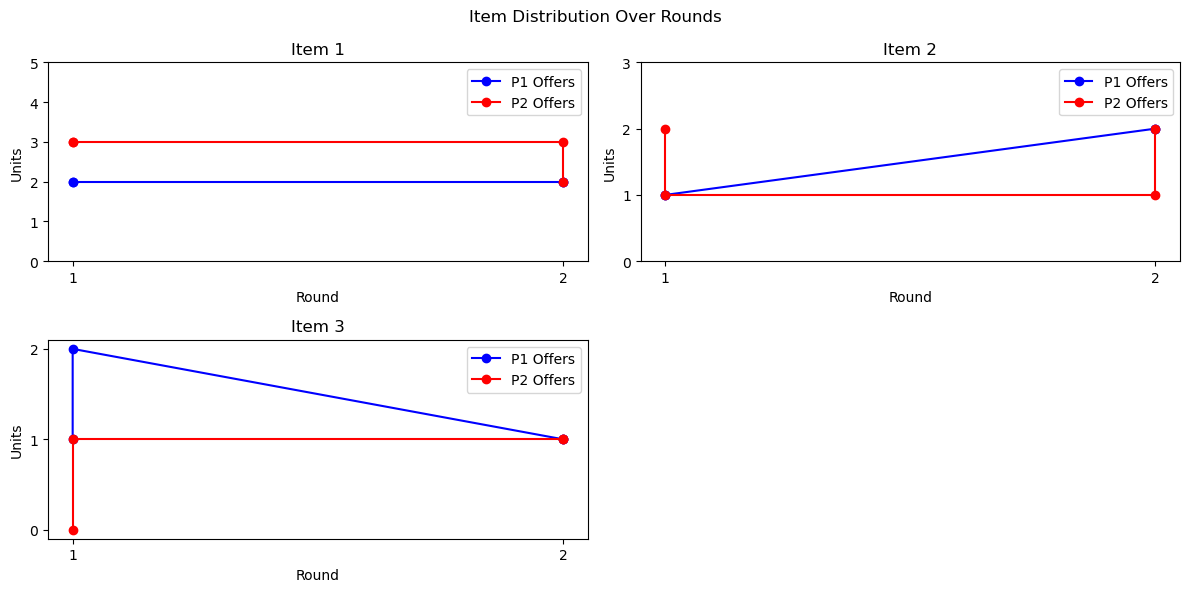

In [68]:
plot_offer_evolution(game, rounds, p1_offers, p2_offers)

## Negotiation Gap

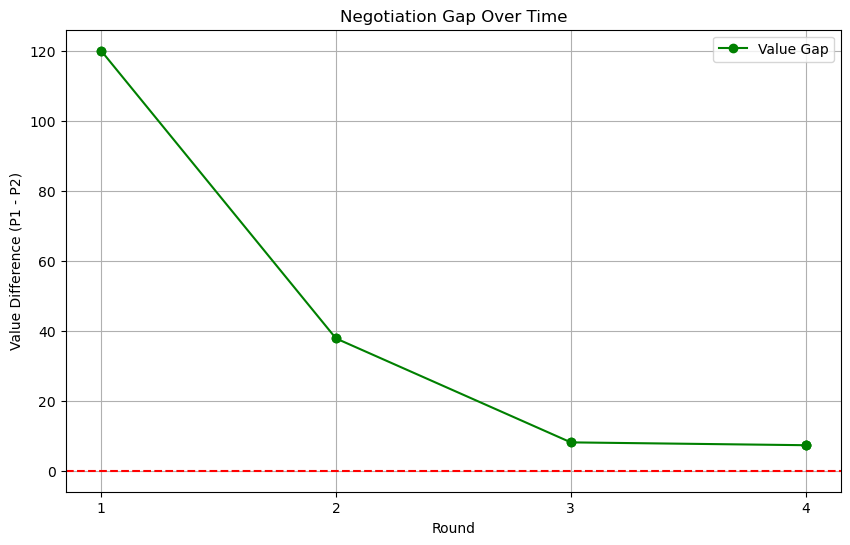

[120.0,
 120.0,
 37.80000000000001,
 37.80000000000001,
 8.100000000000023,
 8.100000000000023,
 7.289999999999992,
 7.289999999999992,
 7.289999999999992]

In [69]:
plot_negotiation_gap(rounds, p1_values, p2_values) 

## Basic Fairness



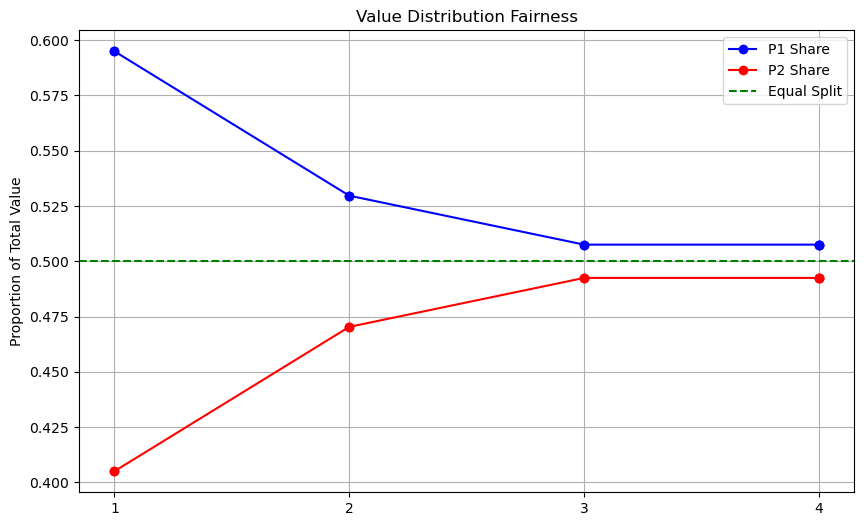

[(0.5949367088607594, 0.4050632911392405),
 (0.5949367088607594, 0.4050632911392405),
 (0.5296610169491525, 0.4703389830508474),
 (0.5296610169491525, 0.4703389830508474),
 (0.5075301204819277, 0.49246987951807225),
 (0.5075301204819277, 0.49246987951807225),
 (0.5075301204819277, 0.4924698795180723),
 (0.5075301204819277, 0.4924698795180723),
 (0.5075301204819277, 0.4924698795180723)]

In [70]:
plot_fairness(rounds, p1_values, p2_values)

In [71]:
def get_final_division(game):
    if game.current_offer: 
        p2_items = game.current_offer.offer  
        p1_items = [t - g for t, g in zip(game.items, p2_items)]  
        return {
            'P1': p1_items,
            'P2': p2_items
        }
    return None
evaluator = GameEvaluator(game)
outside_offer_rational = evaluator.evaluate_outside_offer_consistency()
final_division = get_final_division(game)
final_division = get_final_division(game)
value_gaps = [abs(p1 - p2) for p1, p2 in zip(p1_values, p2_values)]  # Add this line
fairness = [(p1/(p1+p2), p2/(p1+p2)) for p1, p2 in zip(p1_values, p2_values)]  # Add this line

print("\nNegotiation Evaluation:")
print(f"Outside Offer Rational: {'Yes' if outside_offer_rational else 'No'}")

print("\nBasic Metrics:")
print(f"Final P1 Value: {p1_values[-1]:.2f}")
print(f"Final P2 Value: {p2_values[-1]:.2f}")
print(f"Final Value Gap: {value_gaps[-1]:.2f}")
print(f"Final Fairness Ratio: {fairness[-1][0]:.2f} : {fairness[-1][1]:.2f}")
print("\nFinal Division of Items:")
if final_division:
    print(f"Total Items Available: {game.items}")
    print(f"P1 Received: {final_division['P1']}")
    print(f"P2 Received: {final_division['P2']}")
else:
    print("No deal reached - no items were divided")


Negotiation Evaluation:
Outside Offer Rational: No

Basic Metrics:
Final P1 Value: 245.67
Final P2 Value: 238.38
Final Value Gap: 7.29
Final Fairness Ratio: 0.51 : 0.49

Final Division of Items:
Total Items Available: [5 3 2]
P1 Received: [3, 1, 1]
P2 Received: [2, 2, 1]
